# Dan's code: fitting a GP to data.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [54]:
clusters = pd.read_csv("../data/dbf12.csv")
bench = pd.read_csv("../data/Gyro_Benchmark-Field_Stars.csv")
bench = bench.iloc[bench.Age.values > 0.]
kin = pd.read_csv("../data/mcquillan_kinematic_ages.csv")
clusters

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cluster_name,age_gyr,reddening,source_id,epic_or_kic,ra,dec,BP-RP,(BP-RP)0,Gmag,MGmag,teff,prot
0,Pleiades,0.12,0.12,67618285777617664,EPIC210990525,53.882158,22.823390,0.7103,0.660386,9.7295,3.95639,6291.70,2.7953
1,Pleiades,0.12,0.12,67832346947351424,EPIC211051975,54.046203,23.806264,3.1460,3.096090,17.2698,11.49670,3122.60,0.5490
2,Pleiades,0.12,0.12,64597927335800064,EPIC210977505,54.101510,22.623601,1.7721,1.722190,13.5183,7.74519,4036.81,11.1805
3,Pleiades,0.12,0.12,67724697887107200,EPIC211010818,54.160077,23.145484,3.1703,3.120390,17.5594,11.78630,3110.94,0.3040
4,Pleiades,0.12,0.12,67756789882795008,EPIC211025925,54.485193,23.382239,2.7972,2.747290,15.8874,10.11430,3304.18,0.8969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,Ruprecht147,2.70,0.30,4183867079159884672,EPIC219489683,289.460250,-16.624023,1.8770,1.752500,15.3750,7.71700,4007.67,19.1114
919,Ruprecht147,2.70,0.30,4087824807196545664,EPIC219439085,288.586900,-16.749012,2.0406,1.916100,15.5517,7.89370,3867.11,19.7648
920,Ruprecht147,2.70,0.30,4084617394338908672,EPIC218986703,288.978840,-17.770926,2.1041,1.979600,15.8266,8.16860,3818.26,22.5664
921,Ruprecht147,2.70,0.30,4088060892960421248,EPIC219619241,288.383960,-16.286807,2.2064,2.081900,16.2221,8.56410,3743.76,21.6887


In [52]:
# for k in kin.keys():
#     print(k)

Text(0, 0.5, '$\\mathrm{P_{rot}~[days]}$')

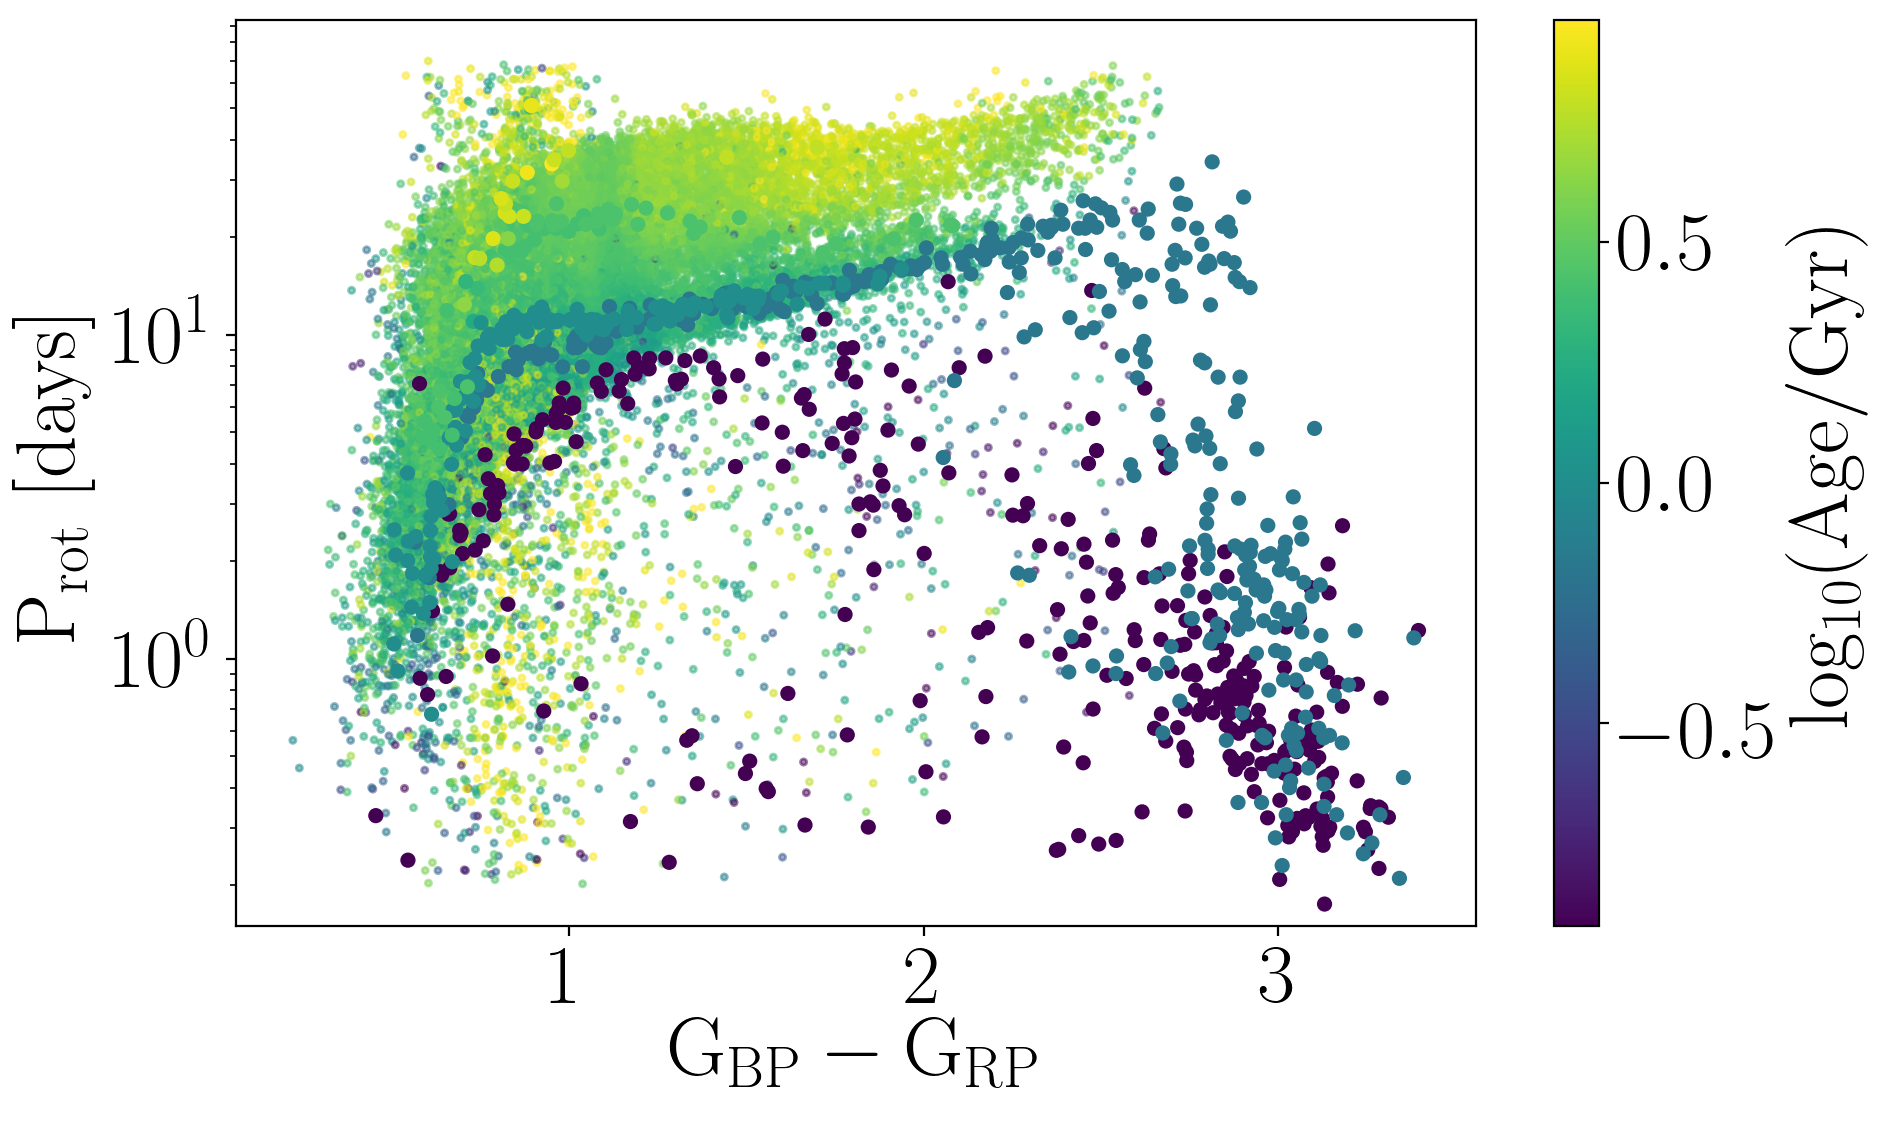

In [51]:
fig = plt.figure(figsize=(10, 6), dpi=200)
vmin, vmax = np.log10(min(clusters.age_gyr)), np.log10(max(bench.Age))
plt.scatter(kin.bprp_dered, kin.Prot, c=np.log10(kin.kinematic_age),
           s=5, alpha=.5, vmin=vmin, vmax=vmax)
plt.scatter(clusters["(BP-RP)0"], clusters.prot, c=np.log10(clusters.age_gyr),
            s=20, vmin=vmin, vmax=vmax)
plt.scatter(bench["BP-RP"], bench.Prot, c=np.log10(bench.Age),
            s=20, vmin=vmin, vmax=vmax)
plt.yscale("log")
plt.colorbar(label="$\mathrm{log_{10}(Age/Gyr)}$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")

(7000, 3000)

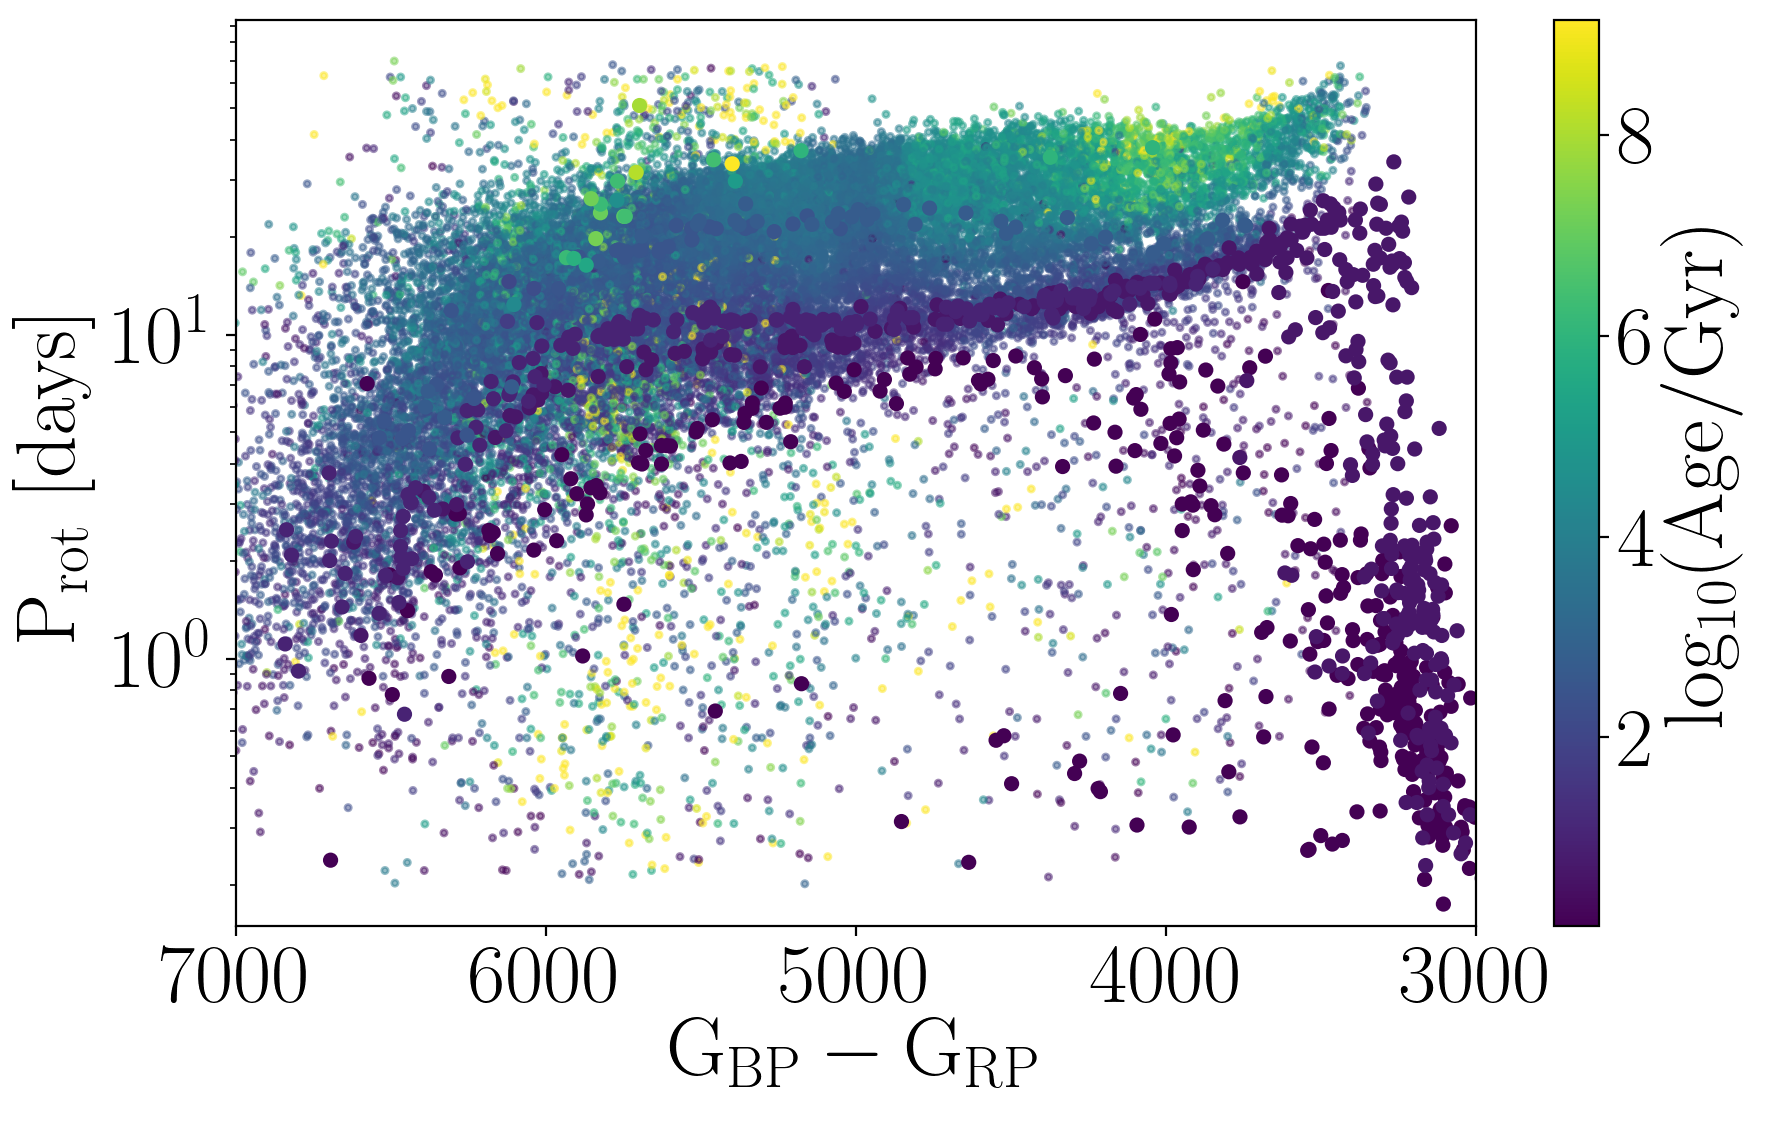

In [57]:
fig = plt.figure(figsize=(10, 6), dpi=200)
vmin, vmax = min(clusters.age_gyr), max(bench.Age)
plt.scatter(kin.color_teffs, kin.Prot, c=kin.kinematic_age,
           s=5, alpha=.5, vmin=vmin, vmax=vmax)
plt.scatter(clusters["teff"], clusters.prot, c=clusters.age_gyr,
            s=20, vmin=vmin, vmax=vmax)
plt.scatter(bench["Teff_1"], bench.Prot, c=bench.Age,
            s=20, vmin=vmin, vmax=vmax)
plt.yscale("log")
plt.colorbar(label="$\mathrm{log_{10}(Age/Gyr)}$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.xlim(7000, 3000)

,Name,Benchmark,Prot,e_Prot,Prot_Source,Age,Age_lower,Age_upper,Age_Source,Teff_1,...,Rad,b_Rad,B_Rad,Lum,b_Lum,B_Lum,RAJ2000,e_RAJ2000,DEJ2000,e_DEJ2000
0,Sun,Yes,26.0,0.0,Unsure,4.567,4.557,4.577,Meteorite Reference,5772,...,0.00,0.00,0.00,0.000,0.000,0.000,0.000000,0.0000,0.000000,0.0000
1,alpha Cen B,Yes,37.0,0.0,Measured from X-ray and UV data by DeWarf et a...,6.000,5.000,7.000,Mamajek 2014 and references therein,5178,...,0.00,0.00,0.00,0.000,0.000,0.000,0.000000,0.0000,0.000000,0.0000
2,61 Cyg A,Yes,35.3,0.0,"Donahue+1996, Boro_Saikia+2016",6.000,5.000,7.000,Kervella+2008,4374,...,0.72,0.69,0.76,0.164,0.163,0.164,316.724748,2.9763,38.749416,3.8702
3,61 Cyg B,Yes,37.8,0.0,"Donahue+1996, Boro_Saikia+2016",6.000,5.000,7.000,Kervella+2008,4044,...,0.58,0.45,0.64,0.092,0.092,0.092,316.730267,1.4580,38.742045,1.5179
4,36 Oph A,Yes,20.7,0.0,See footnote 28 in Barnes (2007) which drew on...,0.000,0.000,0.000,NaN,5100,...,0.76,0.67,0.80,0.350,0.349,0.351,258.836599,4.2072,-26.601700,2.7972


In [ ]:
plt.plot

In [12]:
data = pd.read_csv("../../data/calibration_data.csv")
m = np.isfinite(data.teff.values) & np.isfinite(data.period.values) & np.isfinite(data.age_gyr.values)
m &= data.teff.values > 3500
data = data.iloc[m]

mearth = pd.read_csv("../../data/mearth_kinematic_ages.csv")
mteffs = pd.read_csv("../../data/mearth_teffs.csv")
mdf = pd.merge(mearth, mteffs, on="prot", suffixes=["", "_"])
# mask = (mdf.teff.values < 4000) & (mdf.prot.values > .1) & (mdf.kin_age.values > .1) & (mdf.teff.values > 2800)
mask = (mdf.teff.values < 4000) & (mdf.prot.values > 30) & (mdf.kin_age.values > 5) & (mdf.teff.values > 2800)
mask &= np.isfinite(mdf.teff.values) & np.isfinite(mdf.kin_age.values) & np.isfinite(mdf.prot.values)
mdf = mdf.iloc[mask][::1]
np.shape(mdf)

(229, 8)

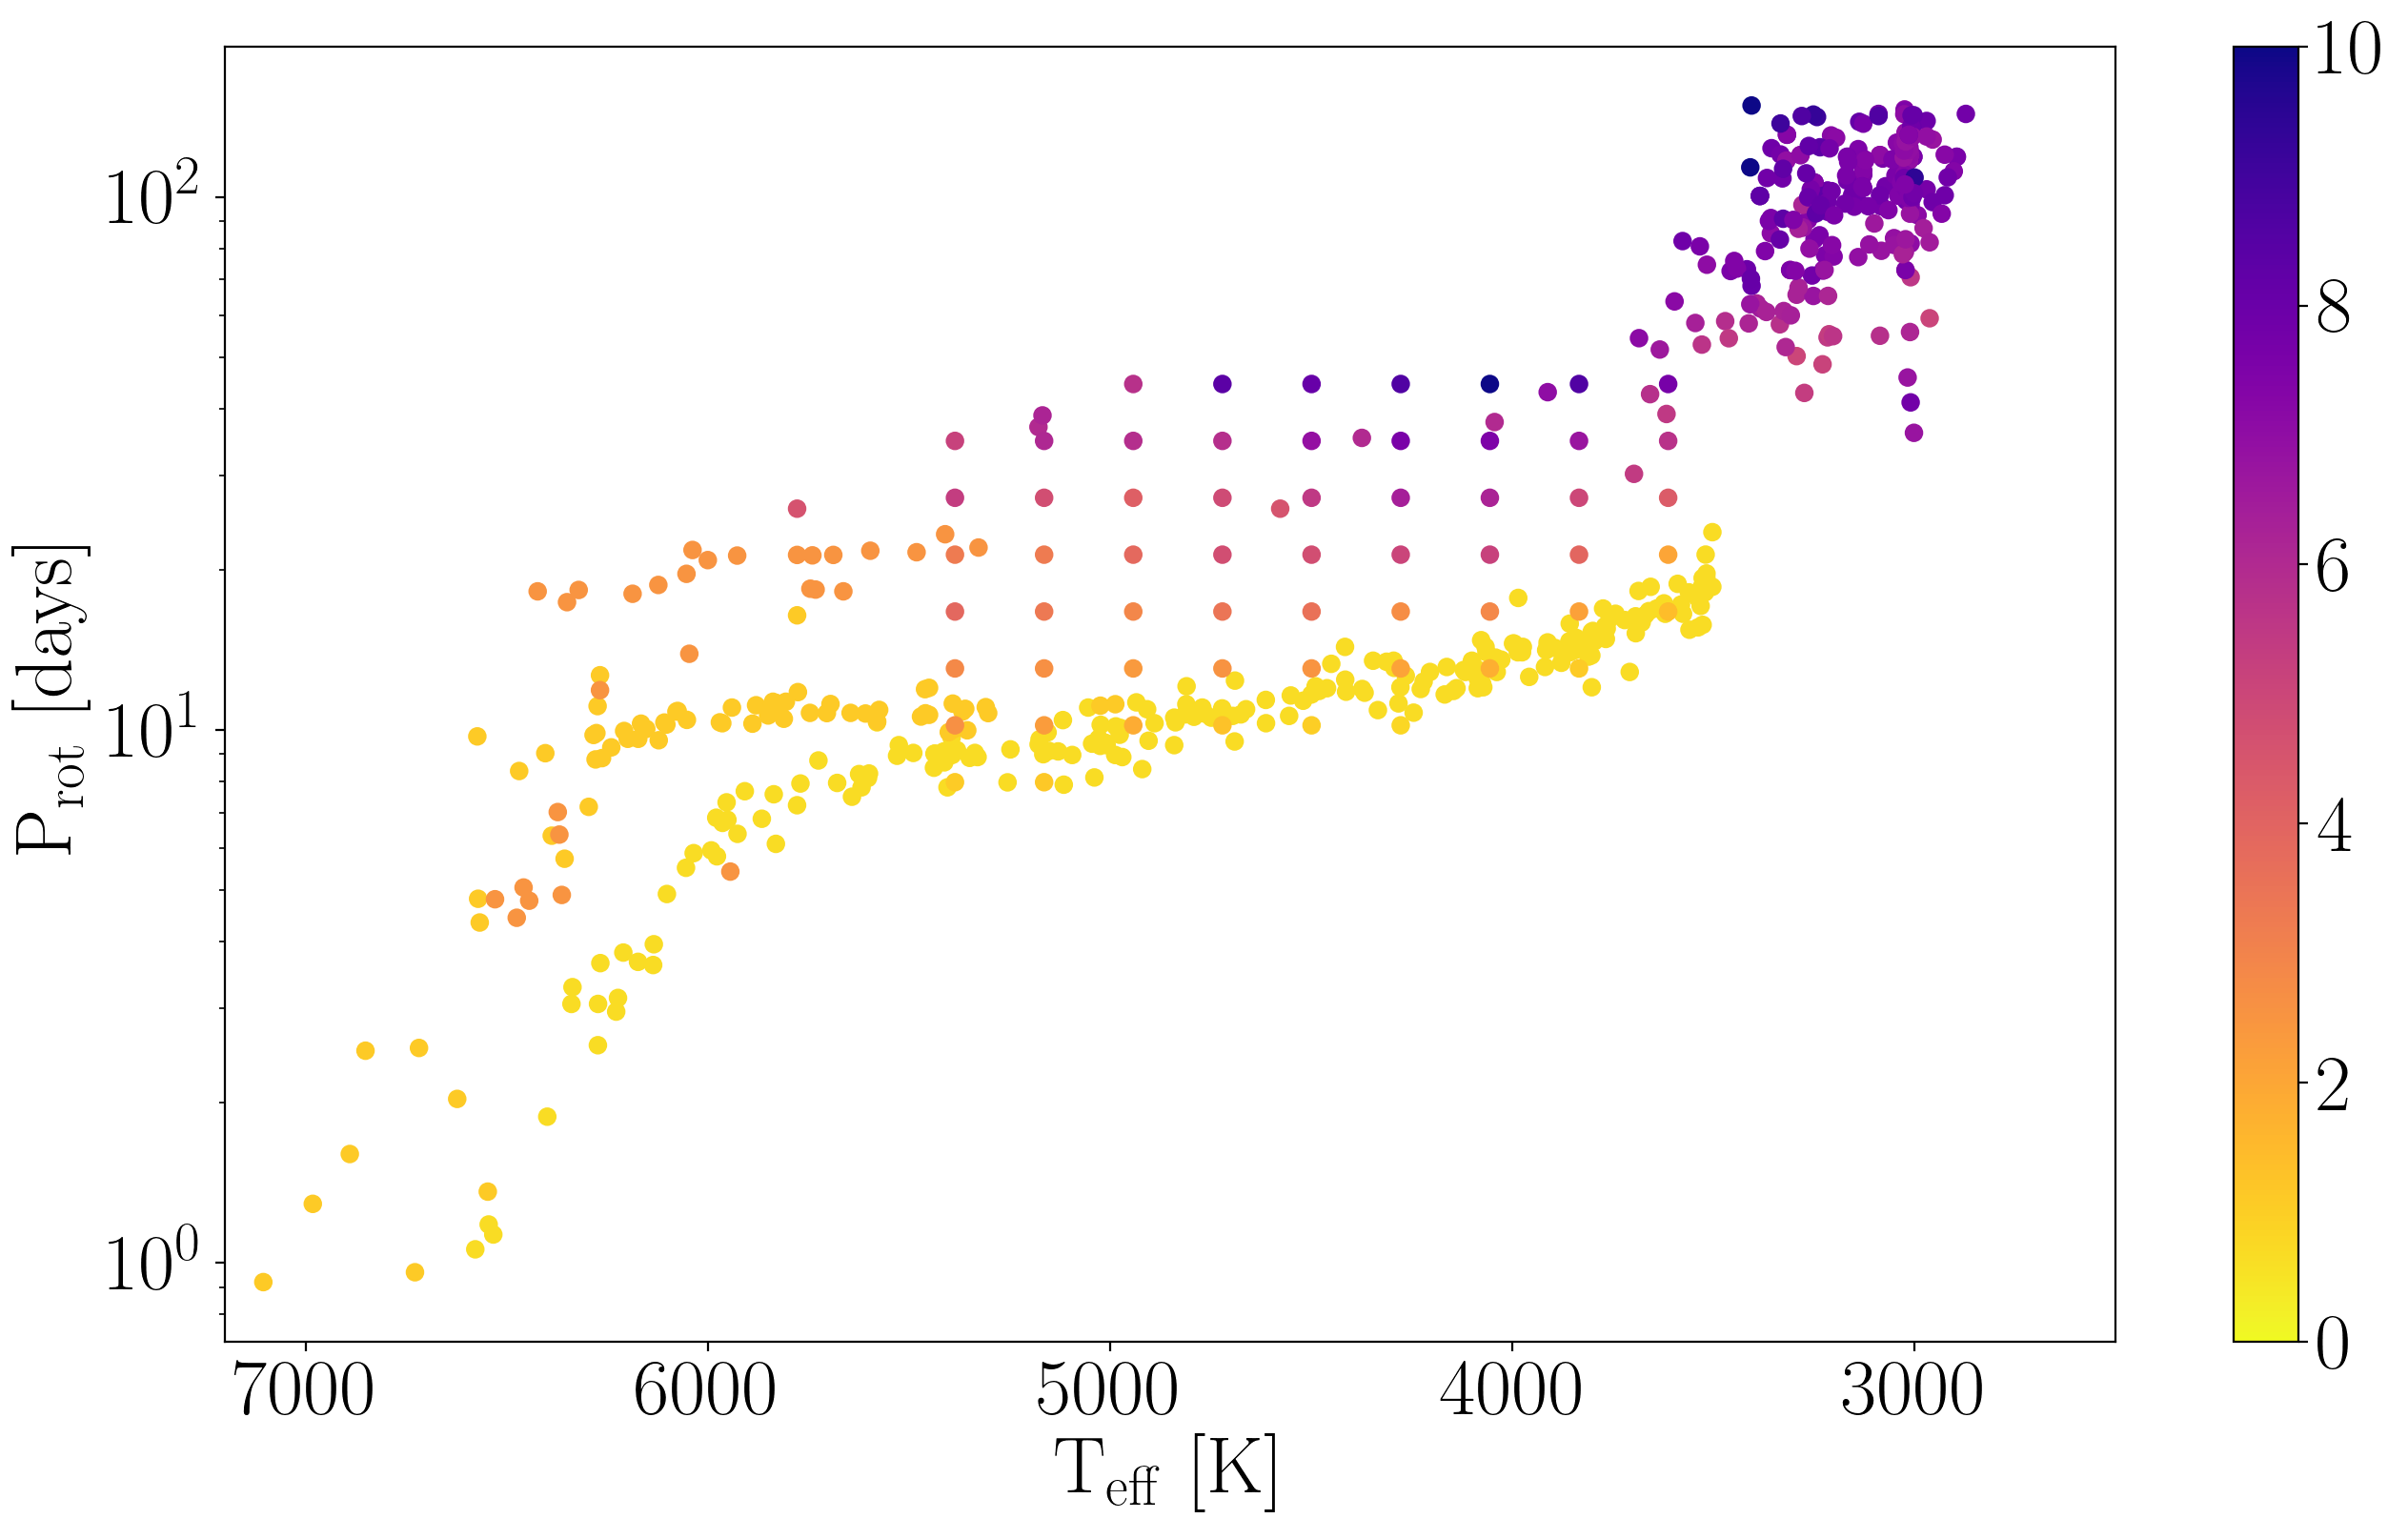

In [13]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(data.teff, data.period, c=data.age_gyr, vmin=0, vmax=10, cmap="plasma_r")
plt.scatter(mdf.teff, mdf.prot, c=mdf.kin_age, vmin=0, vmax=10, cmap="plasma_r")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.xlim(7200, 2500)
plt.yscale("log")
plt.colorbar();

Sort and format data

In [14]:
# without mearth
# inds = np.argsort(data.teff.values)
# x1 = np.array(data.teff.values[inds])
# x2 = np.log(np.array(data.age_gyr.values[inds]))
# y = np.log(np.array(data.period.values[inds]))

# with mearth
teff = np.concatenate((data.teff.values, mdf.teff.values))
age = np.concatenate((data.age_gyr.values, mdf.kin_age.values))
prot = np.concatenate((data.period.values, mdf.prot.values))
inds = np.argsort(teff)
x1 = np.array(teff[inds])
x2 = np.log(np.array(age[inds]))
y = np.log(np.array(prot[inds]))

mu1 = np.mean(x1)
sd1 = np.std(x1)
mu2 = np.mean(x2)
sd2 = np.std(x2)
# x1_norm = (x1 - mu1) / sd1
# x2_norm = (x2 - mu2) / sd2

x2_min = np.min(x2)

xp1 = np.linspace(x1.min() - 500, x1.max() + 100, 1000)
xp2 = np.linspace(x2.min(), x2.max(), 1000)
xg1 = np.linspace(x1.min(), x1.max(), 5)
# xg2 = np.linspace(x2.min(), x2.max(), 7)
xg2 = np.linspace(x2.min(), x2.max(), 10)  # More age lines

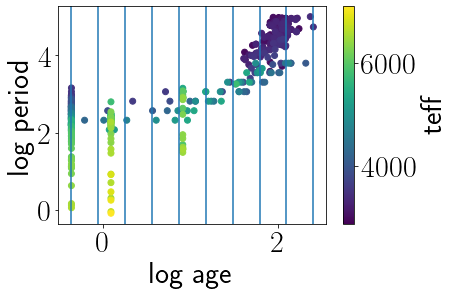

In [15]:
plt.scatter(x2, y, c=x1)
for i, x2_ref in enumerate(xg2):
    plt.axvline(x2_ref)
plt.xlabel("log age")
plt.ylabel("log period")
plt.colorbar(label="teff")

In [17]:
with pm.Model() as model:
    
    teff_break = pm.Normal("teff_break", mu=6000, sigma=500)
    log_period_break_c = pm.Normal("log_period_break_c", mu=0.0, sd=5)
    log_period_break_m = pm.Normal("log_period_break_m", mu=0.0, sd=5)
    log_period_break_b = pm.Normal("log_period_break_b", mu=np.log(10), sd=5)
    log_smooth = pm.Normal("log_smooth", mu=np.log(0.01), sigma=10.0)
    smooth = tt.exp(log_smooth)
    
    def get_log_period_break(x2):
        return log_period_break_c * (x2 - x2_min)**2 + log_period_break_m * (x2 - x2_min) + log_period_break_b
    
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)
    
    log_s2 = pm.Normal("log_s2", mu=1.0, sd=10.0)
    
    # Mean model
    def get_mean_model(x1, x2):
        delta = x1 - teff_break
        brk = get_log_period_break(x2)
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + brk
    
    mean_model = get_mean_model(x1, x2)
    pm.Deterministic("mean_model", mean_model)
    
    # GP
    log_amp = pm.Normal("log_amp", mu=np.log(np.var(y)), sigma=10.0)
    log_ell = pm.Normal("log_ell1", mu=0.0, sigma=10.0, shape=2)
    def get_K(x1, x2, xp1=None, xp2=None):
        X = np.vstack(((x1 - mu1) / sd1, (x2 - mu2) / sd2))
        
        if xp1 is None:
            dX = (X[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
        else:
            Xp = np.vstack(((xp1 - mu1) / sd1, (xp2 - mu2) / sd2))
            dX = (Xp[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
            
        K = tt.exp(log_amp - 0.5 * r2)
        return K
    
    K = get_K(x1, x2)
    K = tt.inc_subtensor(K[np.diag_indices(len(y))], tt.exp(log_s2) + np.zeros_like(y))
    
    alpha = tt.slinalg.solve(K, y - mean_model)
    for i, x2_ref in enumerate(xg2):
        pred_model = get_mean_model(xp1, x2_ref)
        Kp = get_K(x1, x2, xp1, x2_ref + np.zeros_like(xp1))
        pred = tt.dot(Kp, alpha) + pred_model
        pm.Deterministic("pred_{0}".format(i), pred)
    
    # Likelihood
    pm.MvNormal("obs", mu=mean_model, cov=K, observed=y)
    
#     x1_test = pm.Flat("x1_test", shape=(1,))
#     x2_test = pm.Flat("x2_test", shape=(1,))
#     K_test = get_K(x1, x2, x1_test, x2_test)
#     y_test = pm.Deterministic("y_test", tt.dot(K_test, alpha) + get_mean_model(x1_test, x2_test))
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [teff_break, log_period_break_m, log_period_break_b, log_period_break_c])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [log_s2, log_amp, log_ell])
    map_soln = xo.optimize(map_soln)

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -922.6300164511075 -> -918.1417423153632
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -918.1417423153632 -> -918.1003284373834
optimizing logp for variables: [log_period_break_c, log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -918.1003284373834 -> -917.0280029581196
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -917.0280029581196 -> -916.9976419325768
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -916.9976419325768 -> 69.14755899259016
optimizing logp for variables: [log_ell1, log_amp, log_s2, slope_high, slope_low, log_smooth, log_period_break_b, log_period_break_m, log_period_break_c, teff_break]


/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Desired error not necessarily achieved due to precision loss.
logp: 69.14755899259016 -> 74.35797845542855


In [ ]:
import pickle
with open("gp_model.pkl", "wb") as f:
    pickle.dump([model, map_soln], f)

In [8]:
# load mcquillan stars
mcq = pd.read_csv("../../data/Table_1_Periodic.txt")

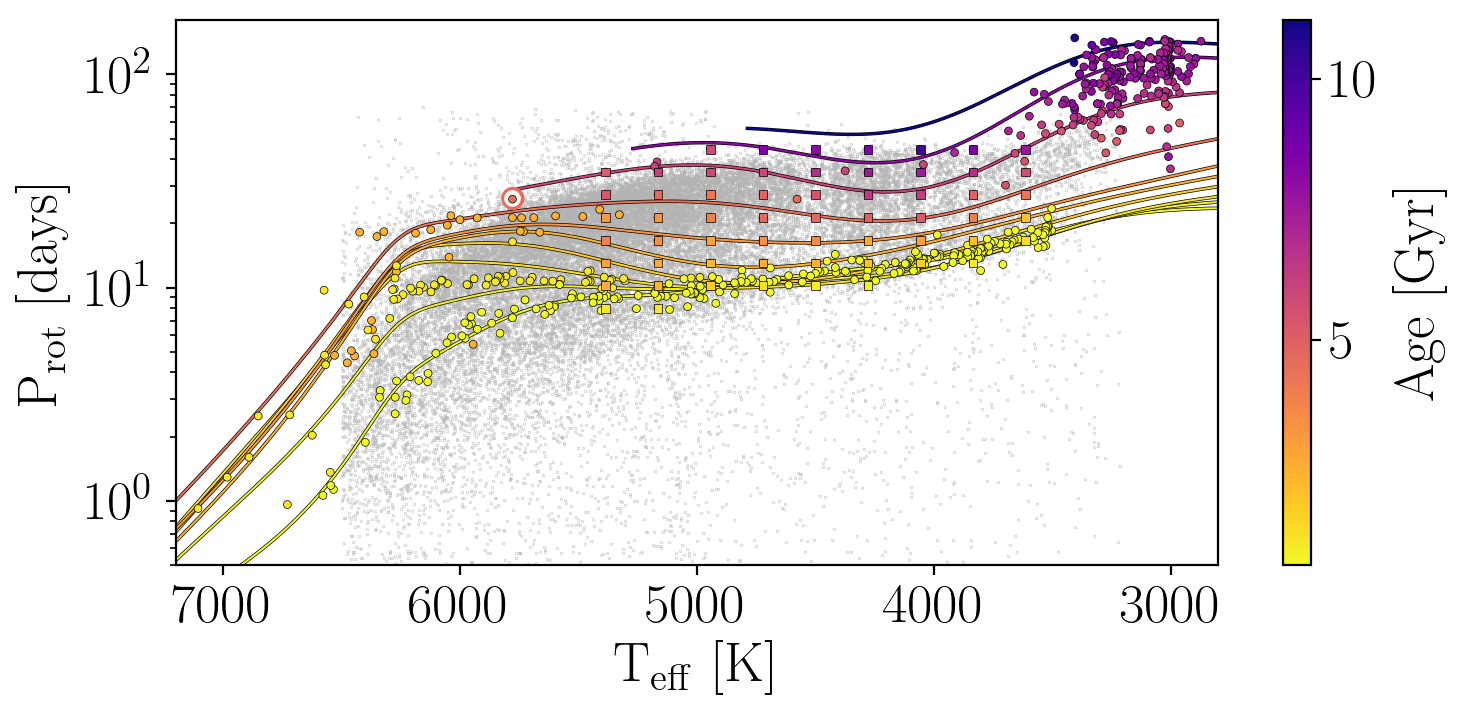

In [9]:
import matplotlib
# cmap = matplotlib.cm.get_cmap("viridis_r")
cmap = matplotlib.cm.get_cmap("plasma_r")


plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 15,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

vmin = np.exp(x2).min()
vmax = np.exp(x2).max()

def get_color(x2):
    return cmap((np.exp(x2) - vmin) / (vmax - vmin))

plt.figure(figsize=(8, 4), dpi=200)

plt.plot(mcq.Teff, mcq.Prot, ".", color=".7", zorder=0, ms=.3, rasterized=True)

# inds = np.argsort(x1)
# plt.plot(x1[inds], map_soln["mean_model"][inds], "k")

# for i, x2_ref in enumerate(xg2):
#     plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
#     plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(x2_ref), lw=0.75)

c = -500
for i in range(len(xg2)-1, len(xg2)):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)
    
c = -400
for i in range(len(xg2)-2, len(xg2)-1):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)
    
c = -300
for i in range(len(xg2)-3, len(xg2)-2):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)

for i in range(0, len(xg2)-3):
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(xg2[i]), lw=0.75)

plt.scatter(x1, np.exp(y), c=np.exp(x2), cmap=cmap, vmin=vmin, vmax=vmax, s=8, edgecolor="k",
            linewidth=0.25, zorder=100)
plt.scatter(data.teff.values[-60:-1], data.period.values[-60:-1], c=data.age_gyr.values[-60:-1], cmap=cmap,
            vmin=vmin, vmax=vmax, s=10, marker="s", edgecolor="k", linewidth=0.25, zorder=101)
plt.scatter([data.teff.values[-1]-1.5], [data.period.values[-1]+.2], c=[data.age_gyr.values[-1]], cmap=cmap,
            vmin=vmin, vmax=vmax, s=70, edgecolor="",
            linewidth=0.25, zorder=98)
plt.plot([data.teff.values[-1]+1], [data.period.values[-1]+.2], "wo", ms=5, zorder=99)
    
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
# plt.xlim(7200, 3400)
plt.xlim(7200, 2800)
# plt.ylim(0.5, 80)
plt.ylim(0.5, 180)
plt.yscale("log")
plt.colorbar(label="$\mathrm{Age~[Gyr]}$");

plt.tight_layout()
# plt.savefig("gp_demo_viridis")
# plt.savefig("gp_demo_viridis.pdf")
# plt.savefig("gp_demo_plasma")
# plt.savefig("gp_demo_plasma.pdf")
plt.savefig("gp_demo_mearth")
plt.savefig("gp_demo_mearth.pdf")

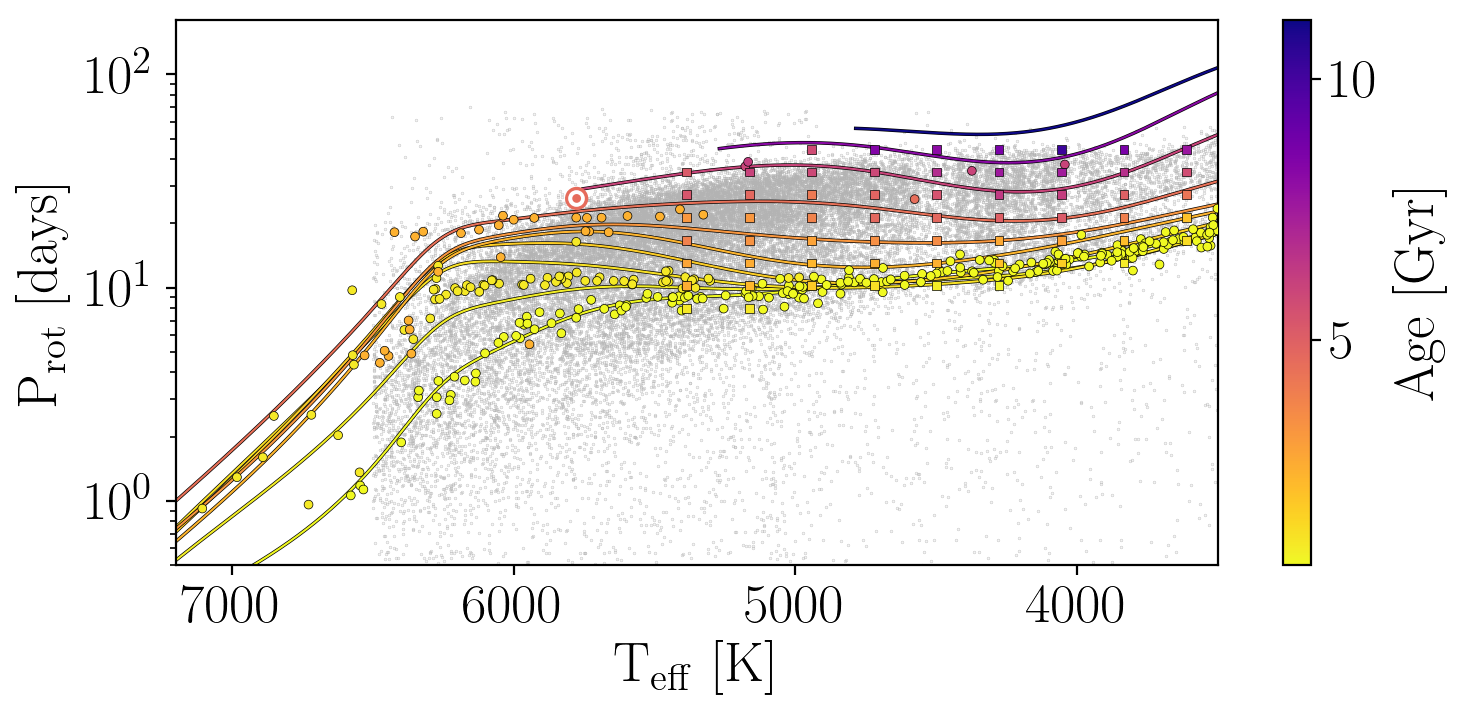

In [19]:
import matplotlib
# cmap = matplotlib.cm.get_cmap("viridis_r")
cmap = matplotlib.cm.get_cmap("plasma_r")


plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 15,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

vmin = np.exp(x2).min()
vmax = np.exp(x2).max()

def get_color(x2):
    return cmap((np.exp(x2) - vmin) / (vmax - vmin))

plt.figure(figsize=(8, 4), dpi=200)

plt.plot(mcq.Teff, mcq.Prot, ".", color=".7", zorder=0, ms=.3, rasterized=True)

# inds = np.argsort(x1)
# plt.plot(x1[inds], map_soln["mean_model"][inds], "k")

# for i, x2_ref in enumerate(xg2):
#     plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
#     plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(x2_ref), lw=0.75)

c = -500
for i in range(len(xg2)-1, len(xg2)):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)
    
c = -400
for i in range(len(xg2)-2, len(xg2)-1):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)
    
c = -300
for i in range(len(xg2)-3, len(xg2)-2):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)

for i in range(0, len(xg2)-3):
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(xg2[i]), lw=0.75)

# plt.scatter(x1, np.exp(y), c=np.exp(x2), cmap=cmap, vmin=vmin, vmax=vmax, s=8, edgecolor="k",
#             linewidth=0.25, zorder=100)
plt.scatter(data.teff.values[:-60], data.period.values[:-60], c=data.age_gyr.values[:-60], cmap=cmap,
            vmin=vmin, vmax=vmax, s=10, edgecolor="k", linewidth=0.25, zorder=101)
plt.scatter(data.teff.values[-60:-1], data.period.values[-60:-1], c=data.age_gyr.values[-60:-1], cmap=cmap,
            vmin=vmin, vmax=vmax, s=10, marker="s", edgecolor="k", linewidth=0.25, zorder=101)
plt.scatter([data.teff.values[-1]-1.5], [data.period.values[-1]+.2], c=[data.age_gyr.values[-1]], cmap=cmap,
            vmin=vmin, vmax=vmax, s=70, edgecolor="",
            linewidth=0.25, zorder=98)
plt.plot([data.teff.values[-1]+1], [data.period.values[-1]+.2], "wo", ms=5, zorder=99)
plt.scatter([data.teff.values[-1]-1.5], [data.period.values[-1]+.2], c=[data.age_gyr.values[-1]], cmap=cmap,
            vmin=vmin, vmax=vmax, s=10, edgecolor="",
            linewidth=0.25, zorder=100)
    
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
# plt.xlim(7200, 3400)
plt.xlim(7200, 3500)
# plt.ylim(0.5, 80)
plt.ylim(0.5, 180)
plt.yscale("log")
plt.colorbar(label="$\mathrm{Age~[Gyr]}$");

plt.tight_layout()
plt.savefig("gp_demo_background")
plt.savefig("gp_demo_background.pdf")